## Work on real Merian image
Several updates:


In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack, vstack
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import pickle
from IPython.display import clear_output

In [2]:
kuaizi.set_env(project='Merian', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/Merian/'

In [3]:
obj_cat = Table.read('./Cutout/stars/stars-2022-04-25.fits')
obj_cat['id'] = obj_cat['name']

In [24]:
obj_cat[['id', 'ra', 'dec']].write('/tigress/jiaxuanl/public_html/galary/catalogs/merian_stars/stars_220425.txt', 
                                   format='ascii')

### Step-by-step

165, 193, 201, 259, 286, 296, 312, 396,
        449, 484]),)

In [4]:
import sys
sys.path.append('/home/jiaxuanl/software/astrometry.net-0.89')
sys.path.append('/home/jiaxuanl/Research/Packages/tractor/')
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/')
from kuaizi.tractor.fit import tractor_hsc_sep_blob_by_blob
from kuaizi.tractor.utils import getTargetProperty

array([109, 162, 163, 252, 487, 488])

In [119]:
channels = list('grizy') + ['N708', 'N540']

obj = obj_cat[10]
obj_id = obj['id']

cutout = []
for filt in channels:
    if 'N' in filt:
        cutout.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_deepCoadd_calexp.fits")))
    else:
        cutout.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}.fits')))

psf_list = []
for filt in channels:
    if 'N' in filt:
        psf_list.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_psf.fits")))
    else:
        psf_list.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}_psf.fits')))

# Reconstruct data
images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
hsc_data = Data(images=images,
                weights=weights,
                wcs=w, psfs=psf_pad, channels=channels)

Text(0.5, 1.0, 'Merian N708')

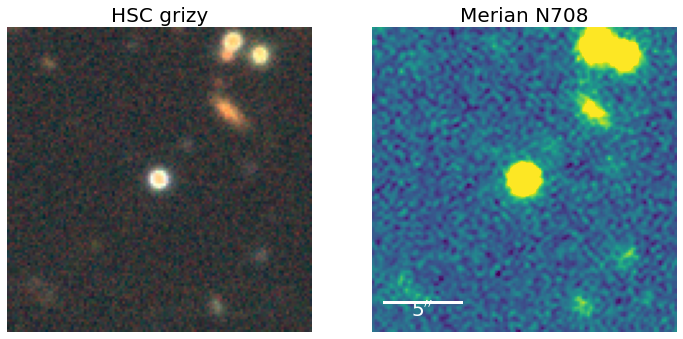

In [120]:
# Visualize our data, optional
import scarlet

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(4)

img_rgb = scarlet.display.img_to_rgb(
    hsc_data.images[:4, ...],
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 12))

ax1.imshow(img_rgb, origin='lower', alpha=1)
ax1.axis('off')
ax1.set_title('HSC grizy', fontsize=20)

ax2 = display_single(hsc_data.images[-1], ax=ax2, pixel_scale=0.168)
ax2.axis('off')
ax2.set_title('Merian N708', fontsize=20)

### `1832` i-band
    Detected 6 objects
# Total number of objects: 6
# Central object index in i-band: 0
# Progress: 1 / 6
# Progress: 2 / 6
# Progress: 3 / 6
# Progress: 4 / 6
# Progress: 5 / 6
# Progress: 6 / 6
# Global optimization: Chi2 improvement =  0.16106558


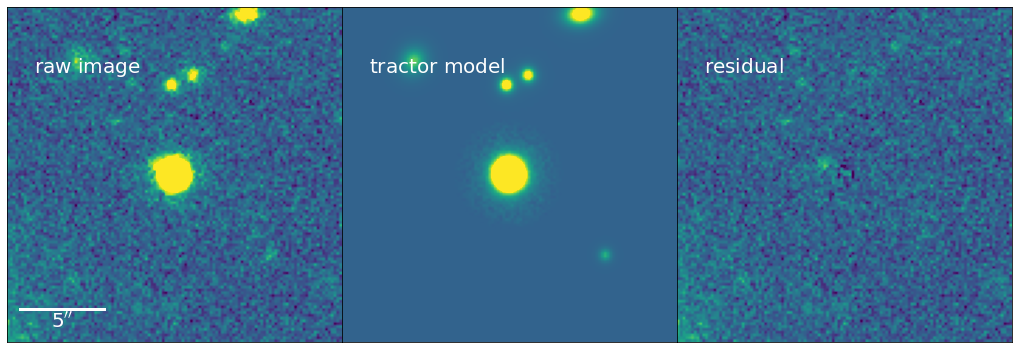

   The chi-square is 1.0799046
PointSource at pixel (58.78, 59.03) with Flux: 488.418


In [41]:
# Start fitting
# fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands
model_dict = {}

ref_filt = 'i'
model_dict[ref_filt], _obj_cat_i = tractor_hsc_sep_blob_by_blob(
    obj, ref_filt, hsc_data.channels, hsc_data, 
    point_source=True,
    freeze_dict={'pos': False, 'shape': False, 'shape.re': False, 
                 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, # don't fix shape/sersic
    verbose=True, show_fig=True)

### `1832` g-band
# Total number of objects: 6
# Central object index in g-band: 0
# Global optimization: Chi2 improvement =  62.82608


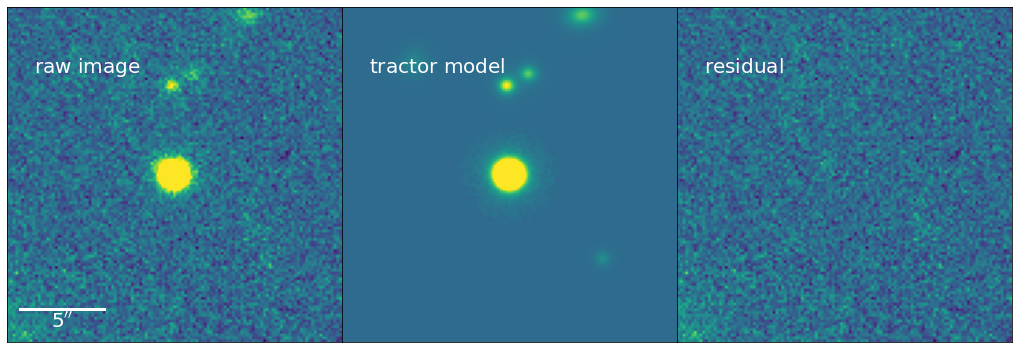

   The chi-square is 1.0013162
PointSource at pixel (58.79, 59.01) with Flux: 138.582


In [42]:
# Fix-all mode
model_dict['g'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'g', hsc_data.channels, hsc_data, 
    fix_all=True, tractor_cat=model_dict['i'].catalog.copy(),
    obj_cat=_obj_cat_i,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True},  
    verbose=True, show_fig=True)

### `1832` N708-band
# Total number of objects: 6
# Central object index in N708-band: 0
# Global optimization: Chi2 improvement =  6.747984


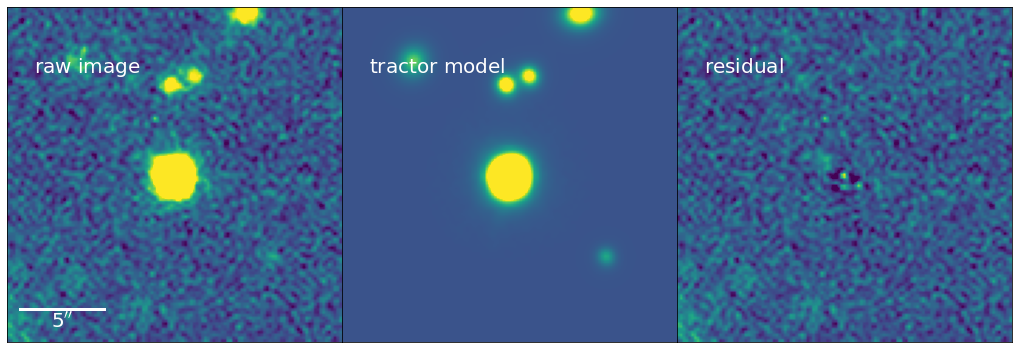

   The chi-square is 1.120622
PointSource at pixel (59.08, 58.46) with Flux: 434.223


In [43]:
# Fix-all mode
model_dict['N708'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'N708', hsc_data.channels, hsc_data, 
    fix_all=True, tractor_cat=model_dict['i'].catalog.copy(),
    obj_cat=_obj_cat_i,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True}, 
    # Since the coordinate system of Merian is different from HSC, we don't fix position. 
    verbose=True, show_fig=True)

### `1832` N540-band
# Total number of objects: 6
# Central object index in N540-band: 0
# Global optimization: Chi2 improvement =  78.02547


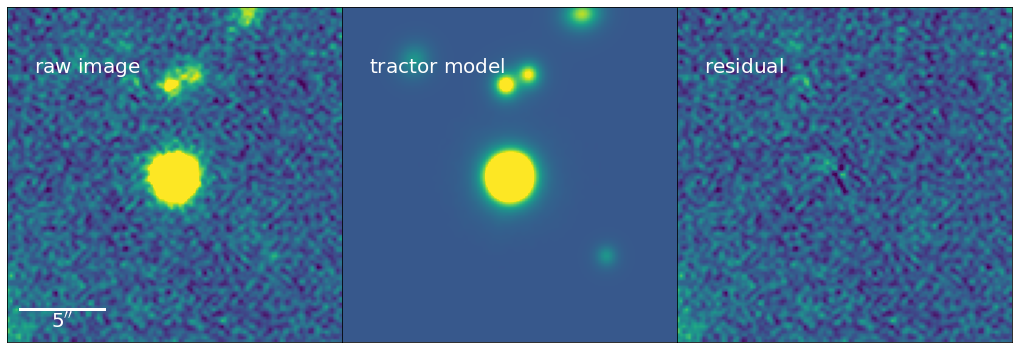

   The chi-square is 1.1037943
PointSource at pixel (59.13, 58.36) with Flux: 223.043


In [44]:
# Fix-all mode
model_dict['N540'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'N540', hsc_data.channels, hsc_data, 
    fix_all=True, tractor_cat=model_dict['i'].catalog.copy(),
    obj_cat=_obj_cat_i,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True}, 
    # Since the coordinate system of Merian is different from HSC, we don't fix position. 
    verbose=True, show_fig=True)

In [45]:
-2.5 * np.log10(getTargetProperty(model_dict['g'])['flux'] / getTargetProperty(model_dict['i'])['flux'])

1.367715837565845

In [57]:
obj['g_gaap_mag'] - obj['i_gaap_mag']

1.0991736691012974

In [23]:
2.5 * np.log10(getTargetProperty(model_dict['N708'])['flux'] / getTargetProperty(model_dict['i'])['flux'])

-0.10841265966749469

In [59]:
(obj['i_gaap_mag'] - obj['N708_gaap_mag'])

-0.09449710511459841

# Batch fitting (forced-photometry, blob-by-blob)

In [5]:
from kuaizi.tractor.utils import initialize_meas_cat, _write_to_row, getTargetProperty

### Tractor modeling for obj 0
### `90906` i-band
    Detected 4 objects
# Total number of objects: 4
# Central object index in i-band: 2
# Progress: 1 / 4
# Progress: 2 / 4
# Progress: 3 / 4
# Progress: 4 / 4
# Global optimization: Chi2 improvement =  0.24548662


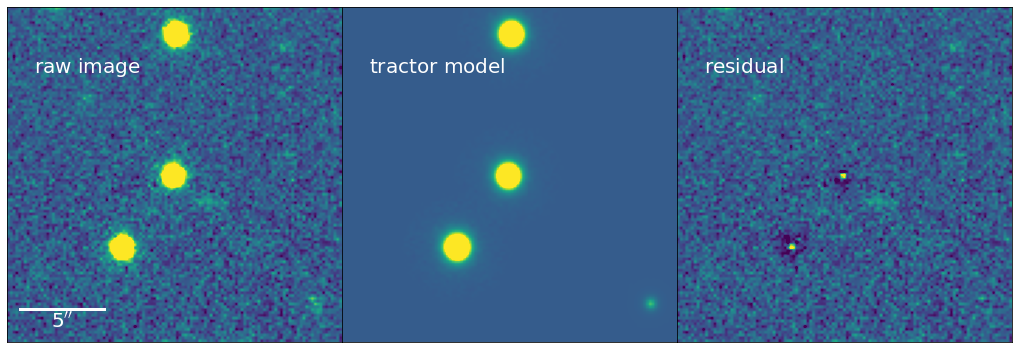

   The chi-square is 1.0374221
PointSource at pixel (58.62, 58.46) with Flux: 138.932
### `90906` g-band
# Total number of objects: 4
# Central object index in g-band: 2
# Global optimization: Chi2 improvement =  12.334115


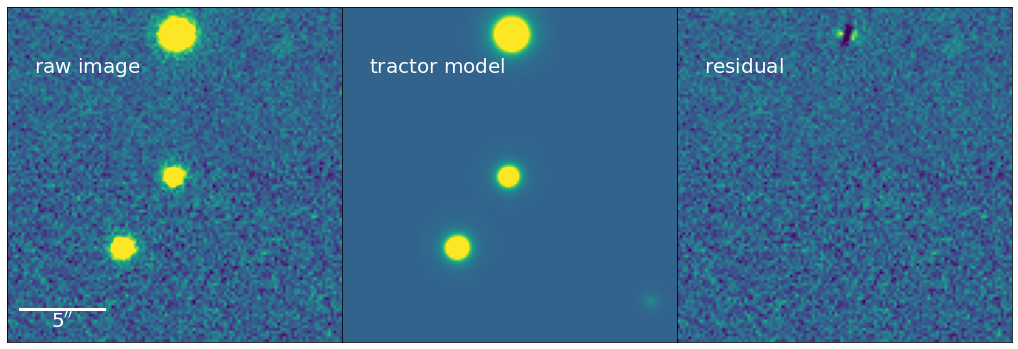

   The chi-square is 1.0501249
PointSource at pixel (58.66, 58.33) with Flux: 33.4326
### `90906` r-band
# Total number of objects: 4
# Central object index in r-band: 2
# Global optimization: Chi2 improvement =  1.8121573


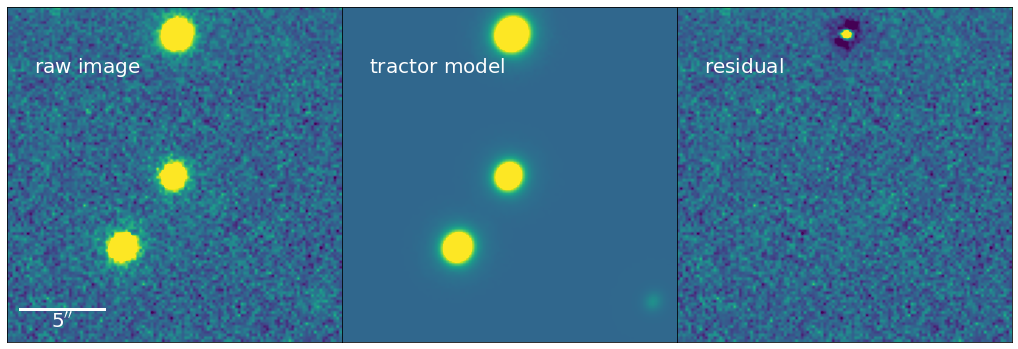

   The chi-square is 1.1287414
PointSource at pixel (58.61, 58.39) with Flux: 87.1992
### `90906` z-band
# Total number of objects: 4
# Central object index in z-band: 2
# Global optimization: Chi2 improvement =  0.087325275


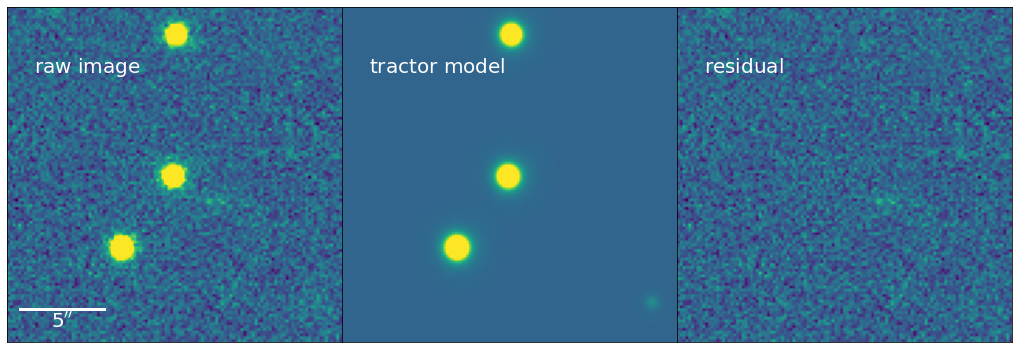

   The chi-square is 0.99919516
PointSource at pixel (58.60, 58.43) with Flux: 162.842
### `90906` y-band
# Total number of objects: 4
# Central object index in y-band: 2
# Global optimization: Chi2 improvement =  0.10295701


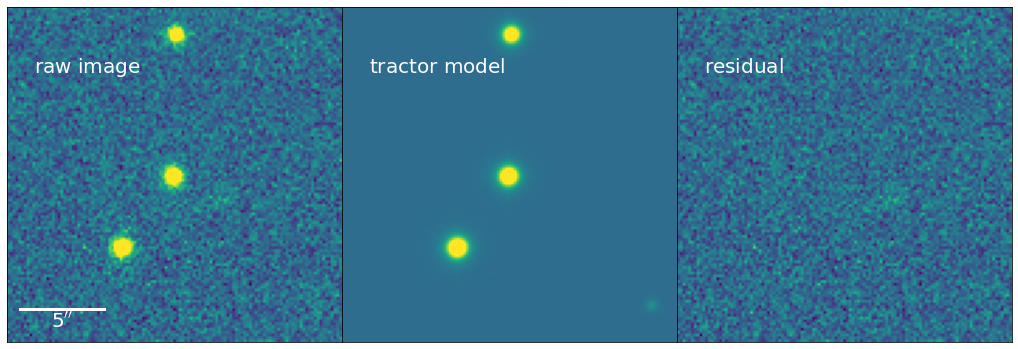

   The chi-square is 1.0160803
PointSource at pixel (58.63, 58.42) with Flux: 186.235
### `90906` N708-band
# Total number of objects: 4
# Central object index in N708-band: 2
# Global optimization: Chi2 improvement =  1.7497325


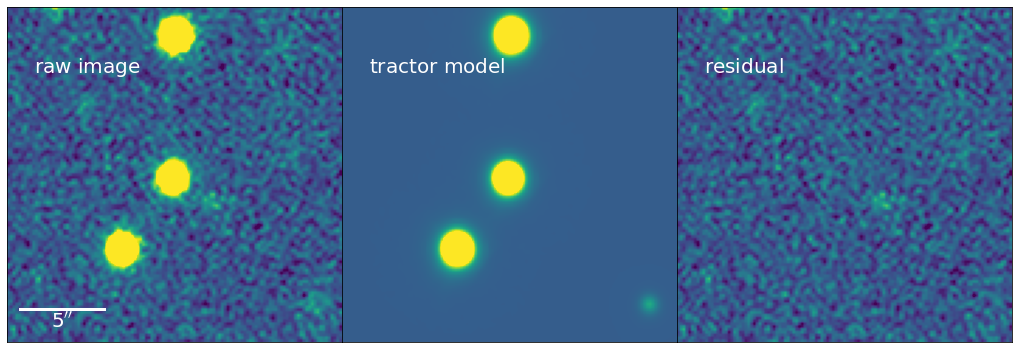

   The chi-square is 0.95981807
PointSource at pixel (58.55, 57.84) with Flux: 112.839
### `90906` N540-band
# Total number of objects: 4
# Central object index in N540-band: 2
# Global optimization: Chi2 improvement =  19.221445


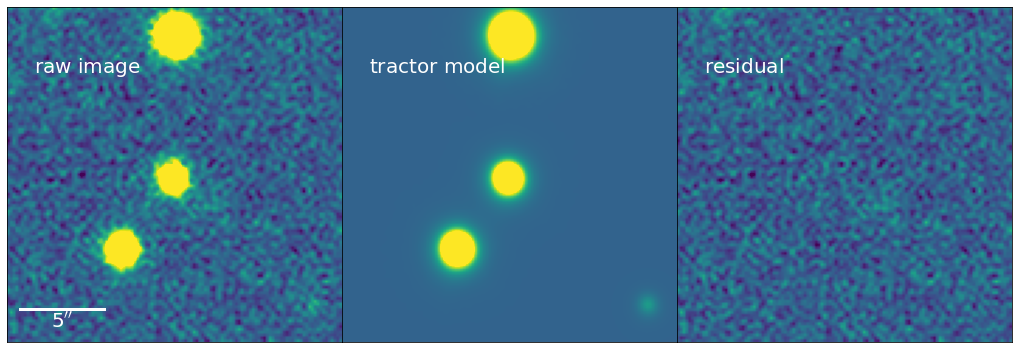

   The chi-square is 0.9575388
PointSource at pixel (58.56, 57.78) with Flux: 56.033


In [6]:
channels = list('grizy') + ['N708', 'N540']
point_source=True

ref_filt = 'i'
forced_channels = [filt for filt in channels if filt != ref_filt]

for k, obj in enumerate(obj_cat[159:159+1]):
    print(f'### Tractor modeling for obj {k}')
    obj_id = obj['id']
    
    cutout = []
    for filt in channels:
        if 'N' in filt:
            cutout.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_deepCoadd_calexp.fits")))
        else:
            cutout.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}.fits')))

    psf_list = []
    for filt in channels:
        if 'N' in filt:
            psf_list.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_psf.fits")))
        else:
            psf_list.append(fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["id"]}_{filt}_psf.fits')))

    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    # Reconstruct data
    from kuaizi.detection import Data
    from kuaizi.utils import padding_PSF

    images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    
    # Start fitting
    model_dict = {}
    # fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands 
    model_dict[ref_filt], _obj_cat_i = tractor_hsc_sep_blob_by_blob(
        obj, ref_filt, data.channels, data, 
        point_source=point_source,
        freeze_dict={'pos': False, 'shape': False, 'shape.re': False, 
                     'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, # don't fix shape/sersic
        verbose=True, show_fig=True)
    
    for filt in forced_channels:
        pos = True
        fix_all = True
        ref_catalog = model_dict[ref_filt].catalog.copy()
        model_dict[filt], _ = tractor_hsc_sep_blob_by_blob(
            obj, filt, data.channels, data,
            fix_all=fix_all, tractor_cat=ref_catalog,
            obj_cat=_obj_cat_i,
            # ref_source=model_dict[ref_filt].catalog[model_dict[ref_filt].target_ind],
            freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True,
                         'sersicindex': True},  # don't fix shape/sersic
            verbose=True, show_fig=True)
    with open(f'./cosmos_{obj["id"]}_tractor.pkl', 'wb') as f:
        pickle.dump(model_dict, f)
    # Write to catalog
#     with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
#         pickle.dump(model_dict, f)

---

In [17]:
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')
import kuaizi
kuaizi.set_matplotlib(style='JL', usetex=True, dpi=70)
from carpenter.display import display_merian_cutout_rgb, SBP_single
from carpenter.utils import SBP_star

In [18]:
# Visualize our model
channels = list('griz') + ['N708', 'N540']
from kuaizi.tractor.utils import HiddenPrints
with HiddenPrints():
    model_img = np.asarray([
        model_dict[key].getModelImage(
            0, srcs=model_dict[key].catalog[model_dict[key].target_ind:model_dict[key].target_ind+1]
                                     ) for key in channels])

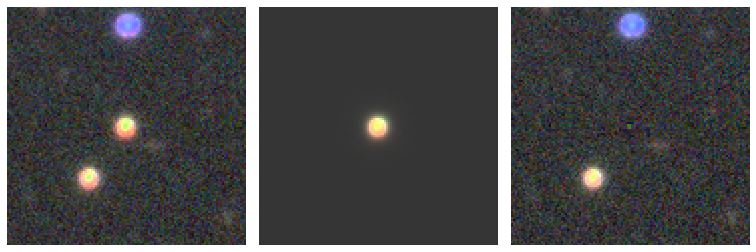

In [20]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(11, 5))

Q = 1.5
stretch = 0.7

_img = np.vstack([data.images[0:4], data.images[-2:]])
_, img_rgb = display_merian_cutout_rgb(_img, filters=list('griz') + ['N708', 'N540'], 
                          ax=ax1, color_norm=None, Q=Q, stretch=stretch, 
                          channel_map=None, N708_strength=3);

_, _ = display_merian_cutout_rgb(model_img, filters=list('griz') + ['N708', 'N540'], 
                                 ax=ax2, Q=Q, stretch=stretch, 
                                 color_norm=None,
                                 channel_map=None);

_, _ = display_merian_cutout_rgb(_img - model_img, filters=list('griz') + ['N708', 'N540'], 
                                 ax=ax3, Q=Q, stretch=stretch, 
                                       color_norm=None,
                                       channel_map=None);

plt.subplots_adjust(wspace=0.03)
plt.tight_layout()
plt.savefig(f"/tigress/jiaxuanl/public_html/Merian/stars/{obj['prefix']}_tractor.png")

In [12]:
### SBP

In [13]:
isolist_dict = {}
for ind in [2, 5, 6]:
    isolist_dict[ind] = SBP_star(model_dict, data, ind=ind)

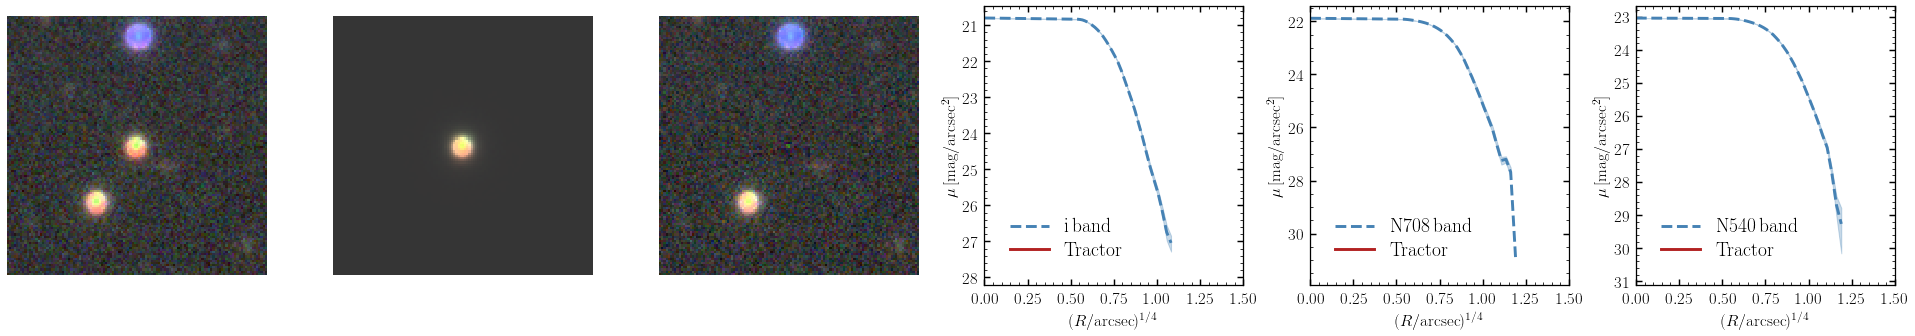

In [16]:
fig, axes = plt.subplots(1, 6, figsize=(27.5, 5), constrained_layout=True)

Q = 1.5
stretch = 0.7

_img = np.vstack([data.images[0:4], data.images[-2:]])
_, img_rgb = display_merian_cutout_rgb(_img, filters=list('griz') + ['N708', 'N540'], 
                          ax=axes[0], color_norm=None, Q=Q, stretch=stretch, 
                          channel_map=None, N708_strength=3);

_, _ = display_merian_cutout_rgb(model_img, filters=list('griz') + ['N708', 'N540'], 
                                 ax=axes[1], Q=Q, stretch=stretch, 
                                 color_norm=None,
                                 channel_map=None);

_, _ = display_merian_cutout_rgb(_img - model_img, filters=list('griz') + ['N708', 'N540'], 
                                 ax=axes[2], Q=Q, stretch=stretch, 
                                       color_norm=None,
                                       channel_map=None);

ax = axes[3]
(isolist_model, isolist_data) = isolist_dict[2]
ax = SBP_single(isolist_data.to_table(), None, 0.168, 27.0, x_min=0.0, x_max=1.5, 
                ax=ax, label='i\,band', linecolor='steelblue', linestyle='--');
ylim = ax.get_ylim()
ylim = (ylim[0]+ 0.6, ylim[1])
ax = SBP_single(isolist_model.to_table(), None, 0.168, 27.0, 
                x_min=0.0, x_max=1.5, ax=ax, label='Tractor', alpha=0.5);
ax.set_ylim(*ylim)

ax = axes[4]
(isolist_model, isolist_data) = isolist_dict[5]
ax = SBP_single(isolist_data.to_table(), None, 0.168, 27.0, x_min=0.0, x_max=1.5, 
                ax=ax, label='N708\,band', linecolor='steelblue', linestyle='--');
ylim = ax.get_ylim()
ylim = (ylim[0]+ 0.6, ylim[1])
ax = SBP_single(isolist_model.to_table(), None, 0.168, 27.0, 
                x_min=0.0, x_max=1.5, ax=ax, label='Tractor', alpha=0.5);
ax.set_ylim(*ylim)

ax = axes[5]
(isolist_model, isolist_data) = isolist_dict[6]
ax = SBP_single(isolist_data.to_table(), None, 0.168, 27.0, x_min=0.0, x_max=1.5, 
                ax=ax, label='N540\,band', linecolor='steelblue', linestyle='--');
ylim = ax.get_ylim()
ylim = (ylim[0]+ 0.6, ylim[1])
ax = SBP_single(isolist_model.to_table(), None, 0.168, 27.0, 
                x_min=0.0, x_max=1.5, ax=ax, label='Tractor', alpha=0.5);
ax.set_ylim(*ylim)

fig.tight_layout()
plt.savefig(f"/tigress/jiaxuanl/public_html/Merian/stars/{obj['prefix']}_tractor.png")

In [142]:
from kuaizi.tractor.utils import HiddenPrints
from photutils.isophote import Ellipse, EllipseGeometry
from photutils.aperture import EllipticalAperture

In [202]:
from carpenter.utils import mask_image
mask = mask_image(data.images[0])

gal = model_dict['i'].catalog[model_dict['i'].target_ind]
geometry = EllipseGeometry(x0=_mean_x, 
                           y0=_mean_y, 
                           sma=1, eps=0,
                           pa=0)

ellipse = Ellipse(data.images[0] * (~mask), geometry)
# isolist_data = ellipse.fit_image(
#                              nclip=3, maxgerr=2.0,
#                              fix_center=False, fix_pa=True, fix_eps=True)

### Comparison

In [25]:
meas_cat = Table.read('./Catalogs/stars/tractor_stars_output_0_500.fits')

In [26]:
meas_cat['mag'] = 22.5 - 2.5 * np.log10(meas_cat['flux'])

In [27]:
gaap_cat = Table.read('./Cutout/stars/stars_obj_cat.fits')

In [28]:
channels = list('grizy') + ['N708', 'N540']

In [29]:
for aper in ['1p0', '1p5', '2p5', '3p0', 'Optimal']:
    gaap_cat[f'gaap_mag_{aper}'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_gaap{aper}Flux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])

In [30]:
gaap_cat[f'psf_mag'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_psfFlux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])

In [31]:
gaap_cat[f'cmodel_mag'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_cModelFlux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])

In [32]:
kuaizi.set_matplotlib(style='JL', usetex=True, dpi=80)

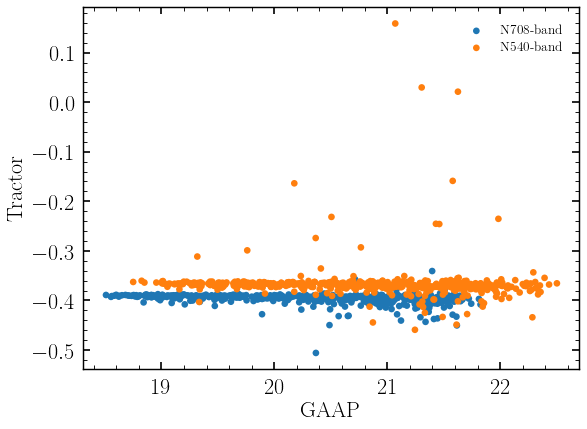

In [382]:
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5,7):
    filt = channels[i]
    plt.scatter(gaap_cat['gaap_mag_1p0'][:, i], 
                gaap_cat['gaap_mag_1p0'][:, i] - meas_cat['mag'][:, i], edgecolors='none',
                label=f'{filt}-band')

plt.xlabel('GAAP')
plt.ylabel('Tractor')
plt.legend(fontsize=12)

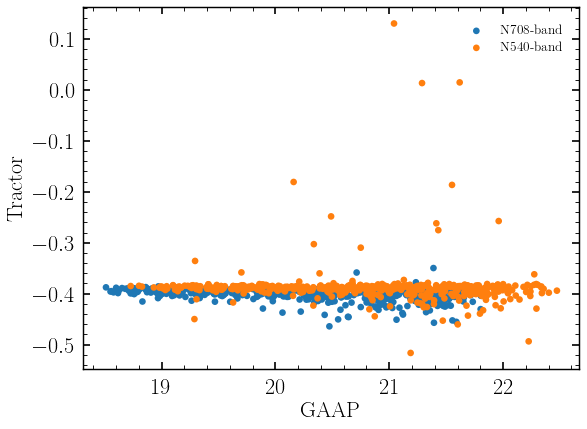

In [389]:
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5,7):
    filt = channels[i]
    plt.scatter(gaap_cat['cmodel_mag'][:, i], 
                gaap_cat['cmodel_mag'][:, i]- meas_cat['mag'][:, i], edgecolors='none',
                label=f'{filt}-band')

plt.xlabel('GAAP')
plt.ylabel('Tractor')
plt.legend(fontsize=12)

In [35]:
kuaizi.set_matplotlib()

Text(0.5, 0.95, 'GAAP 1p0 (x) v.s. Tractor (y)')

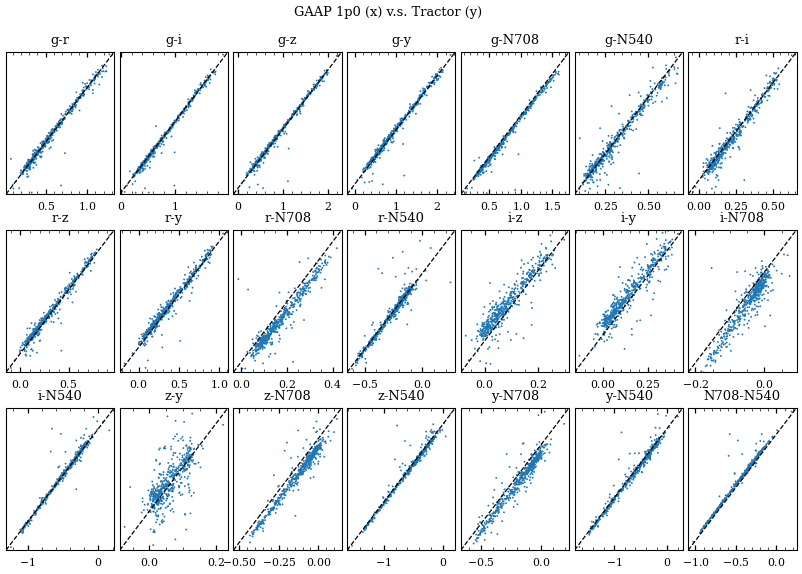

In [36]:
from itertools import combinations
fig, axes = plt.subplots(3, 7, figsize=(17, 11))

for i, (filt1, filt2) in enumerate(combinations(range(len(channels)), 2)):
    plt.sca(axes[i // 7, i % 7])
    aper = '1p0'
    color1 = gaap_cat[f'gaap_mag_{aper}'][:, filt1] - gaap_cat[f'gaap_mag_{aper}'][:, filt2]
    color2 = meas_cat['mag'][:, filt1] - meas_cat['mag'][:, filt2]
    plt.scatter(color1, color2,
                s=5,
                label=aper, edgecolors='none')

    xlim = plt.gca().get_xlim()
    x = np.linspace(*xlim, 2)
    plt.plot(x, x, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(*xlim)
    plt.yticks([])
    plt.title(channels[filt1] + '-' + channels[filt2])
    
plt.subplots_adjust(wspace=0.05, hspace=0.25)
plt.suptitle('GAAP 1p0 (x) v.s. Tractor (y)', y=0.95)

Text(0.5, 0.95, 'GAAP 1p0 (x) v.s. PSF mag (y)')

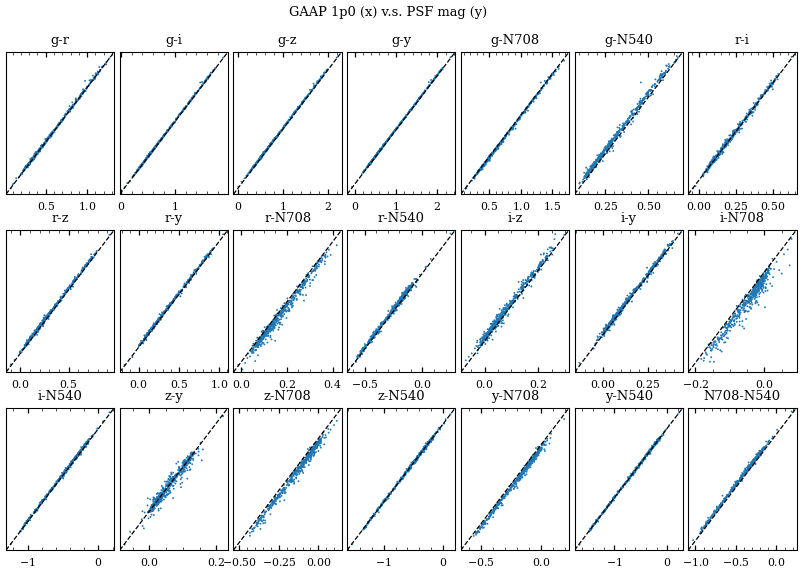

In [37]:
from itertools import combinations
fig, axes = plt.subplots(3, 7, figsize=(17, 11))

for i, (filt1, filt2) in enumerate(combinations(range(len(channels)), 2)):
    plt.sca(axes[i // 7, i % 7])
    aper = '1p0'
    color1 = gaap_cat[f'gaap_mag_{aper}'][:, filt1] - gaap_cat[f'gaap_mag_{aper}'][:, filt2]
    
#     color2 = gaap_cat['cmodel_mag'][:, filt1] - gaap_cat["cmodel_mag"][:, filt2]
    color2 = gaap_cat['psf_mag'][:, filt1] - gaap_cat["psf_mag"][:, filt2]
#     color2 = meas_cat['mag'][:, filt1] - meas_cat['mag'][:, filt2]
    plt.scatter(color1, color2,
                s=5,
                label=aper, edgecolors='none')

    xlim = plt.gca().get_xlim()
    x = np.linspace(*xlim, 2)
    plt.plot(x, x, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(*xlim)
    plt.yticks([])
    plt.title(channels[filt1] + '-' + channels[filt2])
    
plt.subplots_adjust(wspace=0.05, hspace=0.25)
plt.suptitle('GAAP 1p0 (x) v.s. PSF mag (y)', y=0.95)

Text(0.5, 0.92, 'Stars')

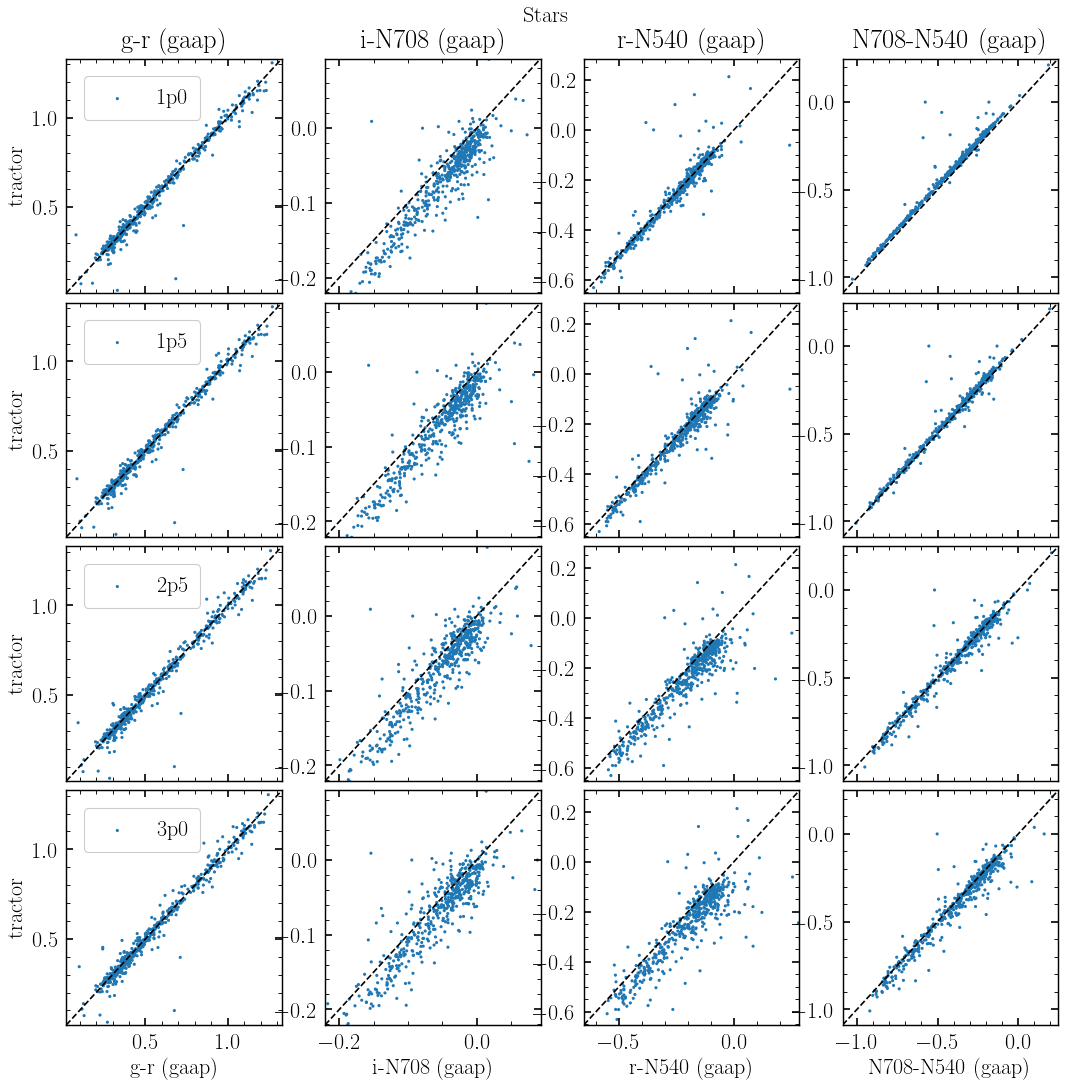

In [350]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex='col')

_filt = ((0, 1), (2, 5), (1, 6), (5, 6))

_apers = ['1p0', '1p5', '2p5', '3p0']

for k, aper in enumerate(_apers):
    for i in range(4):
        plt.sca(axes[k, i])
#         aper = '1p5'
        filt1, filt2 = _filt[i]
        color1 = gaap_cat[f'gaap_mag_{aper}'][:, filt1] - gaap_cat[f'gaap_mag_{aper}'][:, filt2]
        color2 = meas_cat['mag'][:, filt1] - meas_cat['mag'][:, filt2]
        label = aper if i == 0 else None
        plt.scatter(color1, color2,
                    s=8,
                    label=label, edgecolors='none')

        xlim = plt.gca().get_xlim()
        x = np.linspace(*xlim, 2)
        plt.plot(x, x, color='k', ls='--')
        plt.xlim(*xlim)
        plt.ylim(*xlim)
        
        if i == 0:
            plt.legend(frameon=True)
        if k == 3:
            plt.xlabel(channels[filt1] + '-' + channels[filt2] + ' (gaap)')
        if k == 0:
            plt.title(channels[filt1] + '-' + channels[filt2] + ' (gaap)')
    axes[k, 0].set_ylabel('tractor')
    
plt.subplots_adjust(hspace=0.04)

plt.suptitle('Stars', y=0.92, fontsize=20)

In [351]:
gi_gaap = (gaap_cat['gaap_mag_1p0'][:, 2] - gaap_cat['gaap_mag_1p0'][:, 5])

In [352]:
gi_tractor = (meas_cat['mag'][:, 2] - meas_cat['mag'][:, 5])

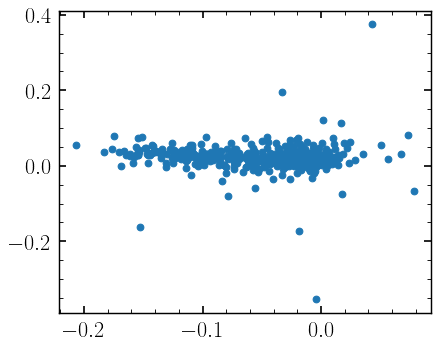

In [353]:
plt.scatter(gi_gaap, gi_gaap - gi_tractor)
# x = np.linspace(-0.2, 0.1)
# plt.plot(x, x)

In [360]:
(gi_gaap - gi_tractor)[159]

0.07504772806309035

In [336]:
np.where(((gi_gaap - gi_tractor) > 0.05) & (gi_gaap < -0.1))

(array([  5, 159, 226, 257, 266, 374, 379, 420, 440, 475, 497]),)